In [9]:
%matplotlib inline 

from __future__ import (print_function, division, absolute_import)

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
               '#bcbd22', '#17becf']

### Code I used to estimate SMF

In [77]:
def compute_smf(sm_array, volume, nb, sm_min, sm_max,
                smf_only=False, return_bins=False):
    """
    Parameters
    ----------
    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3

    nb : number of bins

    sm_min : min of x axis

    sm_max : max of y axis

    Returns
    -------
    x : ndarray
        x axis of SMF in units of log10 M*

    smf : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err : ndarray
        Poisson error
    """

    smf, bin_edges = np.histogram(sm_array, bins=nb,
                                  range=[sm_min, sm_max])

    # bin width in dex
    # !! Only works for constant bin size now
    mass_bin_width = (bin_edges[1] - bin_edges[0])

    # Poison error
    if not smf_only:
        err = np.sqrt(smf)
        # Also normalize the err
        err = (err / volume / mass_bin_width)
        # X-axis
        x = bin_edges[:-1] + (mass_bin_width / 2.0)

    # Normalize
    smf = (smf / volume / mass_bin_width)

    if not smf_only:
        if return_bins:
            return x, smf, err, bin_edges
        return x, smf, err
    # For bootstrap run
    return smf


def bootstrap_resample(X, n_boots=1000):
    """Bootstrap resample an array_like.

    Borrowed from: http://nbviewer.jupyter.org/gist/aflaxman/6871948

    Parameters
    ----------

    X : array_like
      data to resample
    n_boots : int, optional
      Number of bootstrap resamples
      default = 1000

    Results
    -------

    returns X_resamples

    """
    return np.vstack(
        X[np.floor(np.random.rand(len(X))*len(X)).astype(int)]
        for ii in np.arange(n_boots)).T

def bootstrap_smf(sm_array, volume, nb, sm_min, sm_max,
                  n_boots=1000, sm_err=None):
    """Stellar mass function using bootstrap resampling.

    Parameters
    ----------

    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3

    nb : number of bins

    sm_min : min of x axis

    sm_max : max of y axis

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------

    x : ndarray
        x axis of SMF in units of log10 M*

    smf : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err_poison : ndarray
        Poisson error

    smf_boots : ndarray
        Bootstrapped SMFs

    """
    x, smf, err_poison, bins = compute_smf(sm_array, volume, nb,
                                           sm_min, sm_max,
                                           return_bins=True)

    sm_boots = bootstrap_resample(sm_array, n_boots=n_boots)

    smf_boots = np.vstack(
        compute_smf(sm_boots[:, ii], volume, nb, sm_min, sm_max, smf_only=True)
        for ii in range(n_boots)
    )

    return x, smf, err_poison, smf_boots, bins


def get_smf_bootstrap(logms, volume, nbin, min_logms, max_logms,
                      add_err=None, n_boots=5000, bootstrap=True):
    """Estimate the observed SMF and bootstrap errors.

    Parameters
    ----------
    logms : ndarray
        Log10 stellar mass.

    volume : float
        The volume of the data, in unit of Mpc^3.

    nbin : int
        Number of bins in log10 stellar mass.

    min_logms : float
        Minimum stellar mass.

    max_logms : float
        Maximum stellar mass.

    add_err : float, optional
        Additional error to be added to the SMF.
        e.g. 0.1 == 10%
        Default: None

    bootstrap : bool, optional
        Use bootstrap resampling to measure the error of SMF.
        Default: True

    n_boots : int, optional
        Number of bootstrap resamplings.
        Default: 5000

    """
    smf_boot = bootstrap_smf(logms, volume, nbin,
                             min_logms, max_logms,
                             n_boots=n_boots)
    mass_cen, smf_s, smf_err, smf_b, mass_bins = smf_boot

    # Median values
    if n_boots == 1:
        smf = smf_s
    else:
        smf = np.nanmedian(smf_b, axis=0)
    # 1-sigma errors
    smf_low = np.nanpercentile(smf_b, 16, axis=0,
                               interpolation='midpoint')
    smf_upp = np.nanpercentile(smf_b, 84, axis=0,
                               interpolation='midpoint')

    if add_err is not None:
        smf_err += (smf * add_err)
        smf_low -= (smf * add_err)
        smf_upp += (smf * add_err)

    # Make sure the SMF is above zero
    smf = np.where(smf <= 0.0, 1E-8, smf)
    smf_low = np.where(smf_low <= 0.0, 1E-9, smf_low)
    smf_upp = np.where(smf_upp <= 0.0, 5E-8, smf_upp)

    # Left and right edges of the mass bins
    bins_0 = mass_bins[0:-1]
    bins_1 = mass_bins[1:]

    smf_table = Table()
    smf_table['logm_mean'] = mass_cen
    smf_table['logm_0'] = bins_0
    smf_table['logm_1'] = bins_1
    smf_table['smf'] = smf
    smf_table['smf_err'] = smf_err
    smf_table['smf_low'] = smf_low
    smf_table['smf_upp'] = smf_upp

    return smf_table

### Gather necessary information

#### Read the HSC stellar mass catalog

In [78]:
hsc_mass = Table.read('/Volumes/data/massive/dr16a/sbp/catalog/s16a_wide2_massive_fsps1_imgsub_use.fits')

# Please replace this with the catalog I send around. 
# They are for exactly the same sample 

assert len(hsc_mass) == 38653

#### SMFs from other's works

In [79]:
smf_m13 = Table.read('data/smf_Moustakas_13.txt', format='ascii')

smf_b17 = Table.read('data/smf_Bernardi_17_serExp.txt', format='ascii')

#### Volume for HSC S16A

In [80]:
s16a_area = 146.0

cosmo = FlatLambdaCDM(H0=70.0, Om0=0.300)

s16a_vol = ((cosmo.comoving_volume(np.nanmax(hsc_mass['z_best'])) - 
             cosmo.comoving_volume(np.nanmin(hsc_mass['z_best']))) * 
            (s16a_area / 41254.0)).value

print("# Volume between redshift %4.2f-%4.2f for S16A is %12.2f Mpc^3" % (np.min(hsc_mass['z_best']), np.max(hsc_mass['z_best']),
                                                                   s16a_vol))

# Volume between redshift 0.19-0.52 for S16A is 103569570.25 Mpc^3


#### Mask for the `cenHighMh` and `cenLowMh` samples

In [81]:
# cenHighMh sample
cenhmh_mask = hsc_mass['lambda_redm'] >= 25.0

# cenLowMh sample
cenlmh_mask = ~(hsc_mass['lambda_redm'] > 0)

print(cenhmh_mask.sum(), cenlmh_mask.sum())

206 38385


### Measure SMFs (without correction for incompleteness)

#### CModel

* In your catalog, please replace `MSTAR` with `logm_cmod`

In [82]:
smf_cenhmh_cmod = get_smf_bootstrap(
    hsc_mass[cenhmh_mask]['MSTAR'], s16a_vol, 10, 11.2, 12.4, add_err=0.02
)

smf_cenlmh_cmod = get_smf_bootstrap(
    hsc_mass[cenlmh_mask]['MSTAR'], s16a_vol, 10, 11.2, 12.4, add_err=0.02
)

smf_hsc_cmod = get_smf_bootstrap(
    hsc_mass['MSTAR'], s16a_vol, 11, 11.2, 12.4, add_err=0.02
)

#### 100 kpc mass

In [83]:
smf_cenhmh_m100 = get_smf_bootstrap(
    hsc_mass[cenhmh_mask]['logm_100'], s16a_vol, 10, 11.2, 12.4, add_err=0.02
)

smf_cenlmh_m100 = get_smf_bootstrap(
    hsc_mass[cenlmh_mask]['logm_100'], s16a_vol, 10, 11.2, 12.4, add_err=0.02
)

smf_hsc_m100 = get_smf_bootstrap(
    hsc_mass['logm_100'], s16a_vol, 11, 11.2, 12.4, add_err=0.02
)

#### Maximum 1-D mass

In [84]:
smf_cenhmh_mmax = get_smf_bootstrap(
    hsc_mass[cenhmh_mask]['logm_max'], s16a_vol, 10, 11.2, 12.4, add_err=0.02
)

smf_cenlmh_mmax = get_smf_bootstrap(
    hsc_mass[cenlmh_mask]['logm_max'], s16a_vol, 10, 11.2, 12.4, add_err=0.02
)

smf_hsc_mmax = get_smf_bootstrap(
    hsc_mass['logm_max'], s16a_vol, 11, 11.2, 12.4, add_err=0.02
)

### Making plots

Text(0,0.5,'$\\mathrm{d}N/\\mathrm{d}\\log M_{\\star}\\ $$[{\\mathrm{Mpc}^{-3}}{\\mathrm{dex}^{-1}}]$')

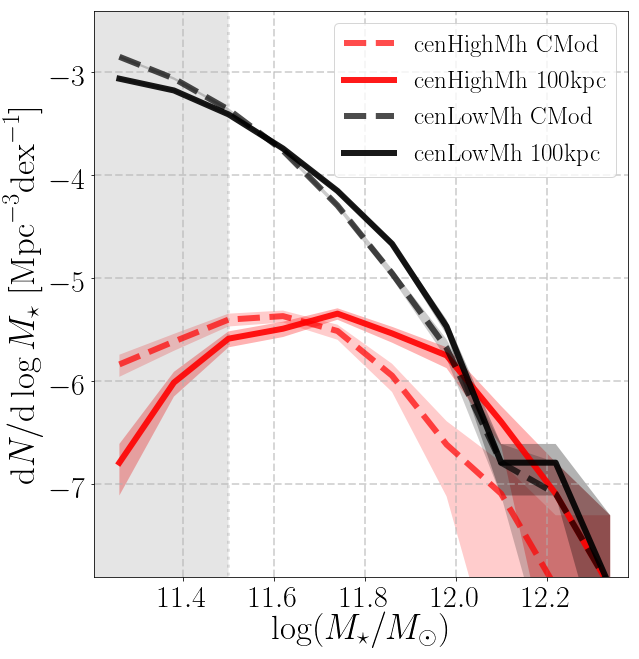

In [69]:
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.fill_between(smf_cenhmh_cmod['logm_mean'], np.log10(smf_cenhmh_cmod['smf_low']), np.log10(smf_cenhmh_cmod['smf_upp']), 
                 alpha=0.2, facecolor='r', label='__no_label__')

ax1.fill_between(smf_cenhmh_m100['logm_mean'], np.log10(smf_cenhmh_m100['smf_low']), np.log10(smf_cenhmh_m100['smf_upp']), 
                 alpha=0.3, facecolor='r', label='__no_label__')

ax1.fill_between(smf_cenlmh_cmod['logm_mean'], np.log10(smf_cenlmh_cmod['smf_low']), np.log10(smf_cenlmh_cmod['smf_upp']), 
                 alpha=0.2, facecolor='k', label='__no_label__')

ax1.fill_between(smf_cenlmh_m100['logm_mean'], np.log10(smf_cenlmh_m100['smf_low']), np.log10(smf_cenlmh_m100['smf_upp']), 
                 alpha=0.3, facecolor='k', label='__no_label__')

ax1.plot(smf_cenhmh_cmod['logm_mean'], np.log10(smf_cenhmh_cmod['smf']), linestyle='--', linewidth=6.0,
         c='r', alpha=0.7, label=r'$\mathrm{cenHighMh\ CMod}$')

ax1.plot(smf_cenhmh_m100['logm_mean'], np.log10(smf_cenhmh_m100['smf']), linestyle='-', linewidth=6.0,
         c='r', alpha=0.9, label=r'$\mathrm{cenHighMh\ 100kpc}$')

ax1.plot(smf_cenlmh_cmod['logm_mean'], np.log10(smf_cenlmh_cmod['smf']), linestyle='--', linewidth=6.0,
         c='k', alpha=0.7, label=r'$\mathrm{cenLowMh\ CMod}$')

ax1.plot(smf_cenlmh_m100['logm_mean'], np.log10(smf_cenlmh_m100['smf']), linestyle='-', linewidth=6.0,
         c='k', alpha=0.9, label=r'$\mathrm{cenLowMh\ 100kpc}$')

ax1.fill_between([11.1, 11.5], [-8.0, -8.0], [-2.0, -2.0], alpha=0.1, facecolor='k', edgecolor='k',
                 linewidth=3, linestyle=':')

ax1.set_xlim(11.205, 12.38)
ax1.set_ylim(-7.9, -2.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.legend(fontsize=25, loc='best')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
               fontsize=35)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
               size=35)

Text(0,0.5,'$\\mathrm{d}N/\\mathrm{d}\\log M_{\\star}\\ $$[{\\mathrm{Mpc}^{-3}}{\\mathrm{dex}^{-1}}]$')

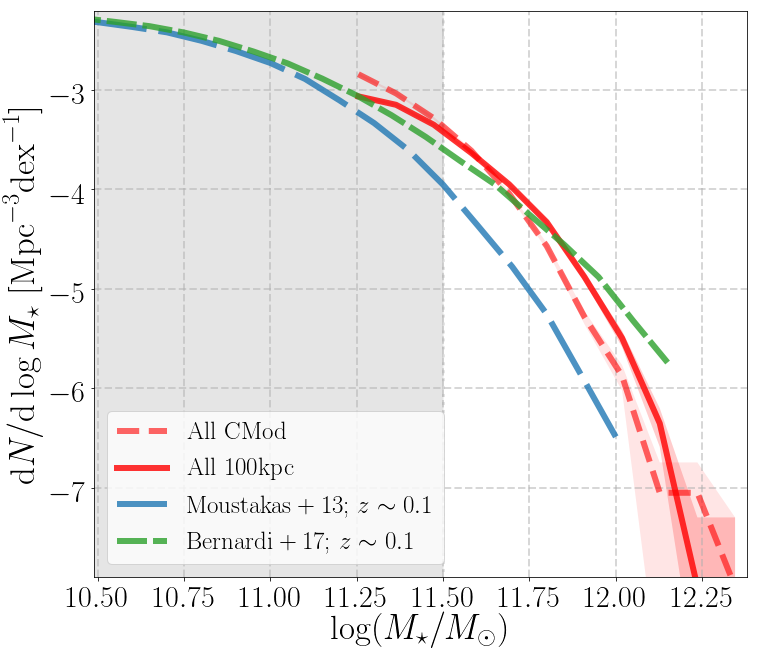

In [85]:
fig = plt.figure(figsize=(11, 9))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.fill_between(smf_hsc_cmod['logm_mean'], np.log10(smf_hsc_cmod['smf_low']), np.log10(smf_hsc_cmod['smf_upp']), 
                 alpha=0.1, facecolor='r', label='__no_label__')

ax1.fill_between(smf_hsc_m100['logm_mean'], np.log10(smf_hsc_m100['smf_low']), np.log10(smf_hsc_m100['smf_upp']), 
                 alpha=0.2, facecolor='r', label='__no_label__')

ax1.plot(smf_hsc_cmod['logm_mean'], np.log10(smf_hsc_cmod['smf']), linestyle='--', linewidth=6.0,
         c='r', alpha=0.6, label=r'$\mathrm{All\ CMod}$')

ax1.plot(smf_hsc_m100['logm_mean'], np.log10(smf_hsc_m100['smf']), linestyle='-', linewidth=6.0,
         c='r', alpha=0.8, label=r'$\mathrm{All\ 100kpc}$')


# Moustakas+2013 
ax1.plot(smf_m13['logM'], smf_m13['logPhi'], linestyle='-', 
         linewidth=6.0, alpha=0.8, dashes=(10,2),
         c=color_cycle[0], label=r'$\mathrm{Moustakas+13;\ }z\sim0.1$')

# Bernardi+2013; SerExp
ax1.plot(smf_b17['col1'], smf_b17['col2'] , linestyle='--', 
         linewidth=6.0, alpha=0.8, dashes=(5,1),
         c=color_cycle[2], label=r'$\mathrm{Bernardi+17;\ }z\sim0.1$')

ax1.fill_between([10.3, 11.5], [-8.0, -8.0], [-2.0, -2.0], alpha=0.1, facecolor='k', edgecolor='k',
                 linewidth=3, linestyle=':')

ax1.set_xlim(10.49, 12.38)
ax1.set_ylim(-7.9, -2.2)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.legend(fontsize=25, loc='lower left')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
               fontsize=35)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
               size=35)

### Only use the 0.3 < z < 0.5

In [86]:
s16a_vol_2 = ((cosmo.comoving_volume(0.5) - cosmo.comoving_volume(0.3)) * (s16a_area / 41254.0)).value

print("# Volume between redshift %4.2f-%4.2f for S16A is %12.2f Mpc^3" % (0.3, 0.5, s16a_vol_2))

# Volume between redshift 0.30-0.50 for S16A is  74605597.73 Mpc^3


In [87]:
z_mask = ((hsc_mass['z_best'] >= 0.30) & 
          (hsc_mass['z_best'] <= 0.50))

print(z_mask.sum())

26811


In [88]:
smf_hsc_cmod_2 = get_smf_bootstrap(
    hsc_mass['MSTAR'][z_mask], s16a_vol_2, 11, 11.2, 12.4, add_err=0.02
)

smf_hsc_m100_2 = get_smf_bootstrap(
    hsc_mass['logm_100'][z_mask], s16a_vol_2, 11, 11.2, 12.4, add_err=0.02
)

smf_hsc_mmax_2 = get_smf_bootstrap(
    hsc_mass['logm_max'][z_mask], s16a_vol_2, 11, 11.2, 12.4, add_err=0.02
)

Text(0,0.5,'$\\mathrm{d}N/\\mathrm{d}\\log M_{\\star}\\ $$[{\\mathrm{Mpc}^{-3}}{\\mathrm{dex}^{-1}}]$')

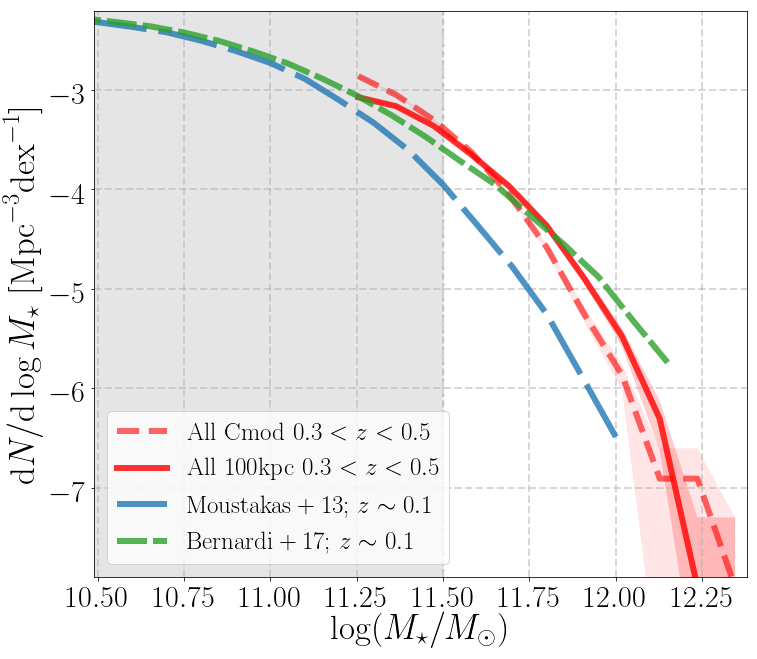

In [92]:
fig = plt.figure(figsize=(11, 9))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.fill_between(smf_hsc_cmod_2['logm_mean'], np.log10(smf_hsc_cmod_2['smf_low']), np.log10(smf_hsc_cmod_2['smf_upp']), 
                 alpha=0.1, facecolor='r', label='__no_label__')

ax1.fill_between(smf_hsc_m100_2['logm_mean'], np.log10(smf_hsc_m100_2['smf_low']), np.log10(smf_hsc_m100_2['smf_upp']), 
                 alpha=0.2, facecolor='r', label='__no_label__')


ax1.plot(smf_hsc_cmod_2['logm_mean'], np.log10(smf_hsc_cmod_2['smf']), linestyle='--', linewidth=6.0,
         c='r', alpha=0.6, label=r'$\mathrm{All\ Cmod}\ 0.3<z<0.5$')

ax1.plot(smf_hsc_m100_2['logm_mean'], np.log10(smf_hsc_m100_2['smf']), linestyle='-', linewidth=6.0,
         c='r', alpha=0.8, label=r'$\mathrm{All\ 100kpc}\ 0.3<z<0.5$')

#ax1.plot(smf_hsc_mmax_2['logm_mean'], np.log10(smf_hsc_mmax_2['smf']), linestyle='-', linewidth=6.0,
#         c='r', alpha=0.9, label=r'$\mathrm{All\ Max}\ 0.3<z<0.5$')

# Moustakas+2013 
ax1.plot(smf_m13['logM'], smf_m13['logPhi'], linestyle='-', 
         linewidth=6.0, alpha=0.8, dashes=(10,2),
         c=color_cycle[0], label=r'$\mathrm{Moustakas+13;\ }z\sim0.1$')

# Bernardi+2013; SerExp
ax1.plot(smf_b17['col1'], smf_b17['col2'] , linestyle='--', 
         linewidth=6.0, alpha=0.8, dashes=(5,1),
         c=color_cycle[2], label=r'$\mathrm{Bernardi+17;\ }z\sim0.1$')

ax1.fill_between([10.3, 11.5], [-8.0, -8.0], [-2.0, -2.0], alpha=0.1, facecolor='k', edgecolor='k',
                 linewidth=3, linestyle=':')

ax1.set_xlim(10.49, 12.38)
ax1.set_ylim(-7.9, -2.2)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.legend(fontsize=25, loc='lower left')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
               fontsize=35)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
               size=35)

### Save the SMFs 

In [90]:
smf_cenhmh_cmod.write('s16a_massive_cenhighmh_cmodel_smf.fits', overwrite=True)
smf_cenhmh_m100.write('s16a_massive_cenhighmh_100kpc_smf.fits', overwrite=True)

smf_cenlmh_cmod.write('s16a_massive_cenlowmh_cmodel_smf.fits', overwrite=True)
smf_cenlmh_m100.write('s16a_massive_cenlowmh_100kpc_smf.fits', overwrite=True)

smf_hsc_cmod.write('s16a_massive_all_cmodel_smf.fits', overwrite=True)
smf_hsc_m100.write('s16a_massive_all_100kpc_smf.fits', overwrite=True)

In [93]:
### 

In [97]:
smf_primus_1 = Table.read('data/primus_smf_z0.3_0.4.fits')
smf_primus_2 = Table.read('data/primus_smf_z0.4_0.5.fits')

Text(0,0.5,'$\\mathrm{d}N/\\mathrm{d}\\log M_{\\star}\\ $$[{\\mathrm{Mpc}^{-3}}{\\mathrm{dex}^{-1}}]$')

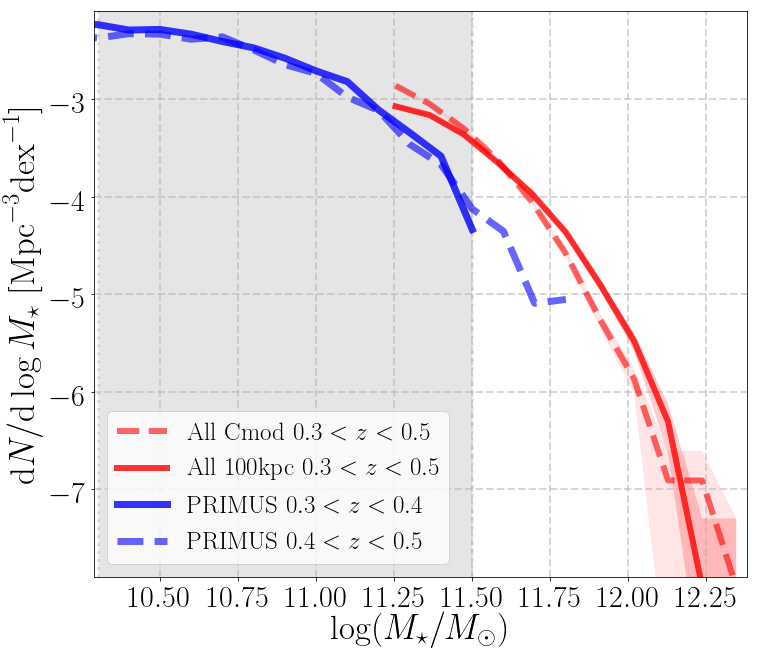

In [99]:
fig = plt.figure(figsize=(11, 9))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.fill_between(smf_hsc_cmod_2['logm_mean'], np.log10(smf_hsc_cmod_2['smf_low']), np.log10(smf_hsc_cmod_2['smf_upp']), 
                 alpha=0.1, facecolor='r', label='__no_label__')

ax1.fill_between(smf_hsc_m100_2['logm_mean'], np.log10(smf_hsc_m100_2['smf_low']), np.log10(smf_hsc_m100_2['smf_upp']), 
                 alpha=0.2, facecolor='r', label='__no_label__')


ax1.plot(smf_hsc_cmod_2['logm_mean'], np.log10(smf_hsc_cmod_2['smf']), linestyle='--', linewidth=6.0,
         c='r', alpha=0.6, label=r'$\mathrm{All\ Cmod}\ 0.3<z<0.5$')

ax1.plot(smf_hsc_m100_2['logm_mean'], np.log10(smf_hsc_m100_2['smf']), linestyle='-', linewidth=6.0,
         c='r', alpha=0.8, label=r'$\mathrm{All\ 100kpc}\ 0.3<z<0.5$')

#ax1.plot(smf_hsc_mmax_2['logm_mean'], np.log10(smf_hsc_mmax_2['smf']), linestyle='-', linewidth=6.0,
#         c='r', alpha=0.9, label=r'$\mathrm{All\ Max}\ 0.3<z<0.5$')

# Moustakas
ax1.plot(smf_primus_1['logm_mean'], np.log10(smf_primus_1['smf']), linestyle='-', linewidth=7.0,
         c='b', alpha=0.8, label=r'$\mathrm{PRIMUS}\ 0.3<z<0.4$')

ax1.plot(smf_primus_2['logm_mean'], np.log10(smf_primus_2['smf']), linestyle='--', linewidth=7.0,
         c='b', alpha=0.6, label=r'$\mathrm{PRIMUS}\ 0.4<z<0.5$')

ax1.fill_between([10.3, 11.5], [-8.0, -8.0], [-2.0, -2.0], alpha=0.1, facecolor='k', edgecolor='k',
                 linewidth=3, linestyle=':')

ax1.set_xlim(10.29, 12.38)
ax1.set_ylim(-7.9, -2.09)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.legend(fontsize=25, loc='lower left')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
               fontsize=35)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
               size=35)